In [27]:
import DataLoader as DL
import SetTransformer_Extrapolating as ST

#to plot data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
import random
from torch.optim.lr_scheduler import ExponentialLR

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from itertools import islice

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

#Plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'
pio.renderers["browser"].executable = "/path/to/your/browser/executable"



In [28]:
folder_path = "../../../Data/3dbsf_txt/"

In [29]:
dataset, targets, labels = DL.load_dataset(folder_path)

/home/dsk2v/PointCloud/BodyScan/ThirdWorkingDraft/DataLoader/../../../Data/3dbsf_txt/


In [30]:
target_label_dict = {target: label for target, label in zip(targets, labels)}

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
# Split data
splitter = DL.DatasetSplitter(validation_ratio=0.2, shuffle=False)
train_data,train_targets, val_data, val_targets = splitter.split_dataset(dataset, targets)

validation_data 10200


In [33]:
# Custom collate function to subssample the point cloud data
def custom_collate(subsample_size):
    def collate_fn(batch):
        subsamples = []
        for data, target in batch:
            num_samples = data.shape[0]
            current_subsample_size = min(subsample_size, num_samples)
            indices = random.sample(range(num_samples), subsample_size)
            subsample = data[indices]
            subsamples.append((subsample, target))

        data, targets = zip(*subsamples)
        data = torch.stack(data, dim=0)
        targets = torch.stack(targets, dim=0)

        return data, targets
    
    return collate_fn

In [34]:
# Define the batch size validation subsample size
# Load only validation data as required for the PCA/t-SNE Visualization
batch_size = 4
val_subsample_size = 10176
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_targets))

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate(subsample_size=val_subsample_size))

val_total_DLbatches = len(val_dataloader)
print('val num batches',val_total_DLbatches)

val num batches 19


In [35]:
# Defining the fine tuning model for Contrastive pretrained model
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_model, additional_layers, final_layer):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.additional_layers = additional_layers
        self.final_layer = final_layer

    def forward(self, inputs, get_embeddings=True,get_embeddings_additional_layer = False):
        _, outputs = self.pretrained_model(inputs, get_embeddings=get_embeddings)
        embeddings = self.additional_layers(outputs)
        outputs = self.final_layer(embeddings)
        if get_embeddings_additional_layer:
            return outputs, embeddings
        return outputs

In [36]:
# Function to get PCA and t-sne fit vectors
def get_tsne_vector(pytorch_model, std_flag=False):
    true_labels = []
    predicted_probs = []
    predicted_labels = []
    val_embeddings_lst = []
    pca = PCA(n_components=2)  # Set the number of components to 2 for 2D visualization
    for i in range(10):
        for batch_data, batch_targets in val_dataloader:
            true_labels.extend(batch_targets.long().tolist())
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)

            # Forward pass - Validation
            with torch.no_grad():
                if std_flag:
                    _,val_embeddings = pytorch_model(batch_data, get_embeddings=True)
                else:
                    _,val_embeddings = pytorch_model(batch_data, get_embeddings_additional_layer=True)
                val_embeddings_cpu = val_embeddings.cpu()  # Copy the tensor to CPU
                val_embeddings_lst.append(val_embeddings_cpu.numpy())

    # Concatenate the embeddings from all batches
    val_embeddings_lst = np.concatenate(val_embeddings_lst, axis=0)

    # Apply PCA
    pca.fit(val_embeddings_lst)  # Convert the tensor to a NumPy array

    # Transform the embeddings using PCA
    pca_transformed = pca.transform(val_embeddings_lst)
    
    tsne = TSNE(n_components=2, perplexity=20, random_state=42)
    X_tsne = tsne.fit_transform(val_embeddings_lst)
    
    return true_labels, pca_transformed, X_tsne, pca

In [37]:
# Load fine tuned model
contrastive_finetuned_model = torch.load('./PCA_Tsne_Visualization/Model_4082287_unmasked_encoder_64_16_128_3_0.05.pth')

In [38]:
# Fit PCA/t-sne models for visualization
true_labels, pca_transformed, X_tsne, pca = get_tsne_vector(contrastive_finetuned_model, std_flag=False)

/home/dsk2v/.conda/envs/my_miniconda_dsk2v_4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/dsk2v/.conda/envs/my_miniconda_dsk2v_4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [39]:
# Get the explained variance ratio
variance_ratio = pca.explained_variance_ratio_
total_variance = 0.0
# Print the variance percentage for each principal component
for i, ratio in enumerate(variance_ratio):
    print(f"Principal Component {i+1}: {ratio * 100:.2f}%")
    total_variance += (ratio * 100)
print(f"Total Principal Component: {total_variance:.2f}%")

Principal Component 1: 20.47%
Principal Component 2: 18.44%
Total Principal Component: 38.91%


In [40]:
# Create a scatter plot with hover labels
fig = go.Figure(data=go.Scatter(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    mode='markers',
    marker=dict(color=true_labels),
    text=[str(label)+ ': '+target_label_dict[label] for label in true_labels],  # Obtain labels from the dictionary
    hovertemplate="%{text}<extra></extra>"
))

fig.update_layout(
    title='PCA Visualization',
    xaxis_title='Component 1',
    yaxis_title='Component 2',
    hovermode='closest'
)

# fig.show()
fig.show(renderer="iframe")  # or renderer="svg"


In [41]:
def plot_original_pointcloud(prefix, file_name, ax, elev=10, azim=10):
    data_path = '../../Data/3dbsf_txt/'
    # Get the absolute path of the file
    file_path = os.path.abspath(os.path.join(os.getcwd(), data_path, file_name))

    # Load data from file
    data = np.loadtxt(file_path)

    # Extract x, y, and z coordinates
    x = data[:, 0]/ 200.0
    y = data[:, 1]/ 200.0
    z = data[:, 2]/ 1500.0
    # Create a 3D scatter plot
    ax.scatter(x, y, z, c=z, cmap='viridis')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(prefix+file_name)

In [42]:
# To plot original 3D body Scan
def scan_plot(rows, azim = 0, elev = 5):
    fig, axs = plt.subplots(len(rows), len(rows[0]), subplot_kw={'projection': '3d'}, figsize=(20, 12))

    for i,row in enumerate(rows):
        for j,column in enumerate(row):
            plot_original_pointcloud(str(column)+':',target_label_dict[column]+'.txt',axs[i, j],azim=azim, elev=elev)
    # Adjust spacing between subplots
    # plt.subplots_adjust(left=0.5)
    # plt.subplots_adjust(right=0.5)

    plt.tight_layout()
    plt.show()

In [43]:
# With help of chatGPT
# Create a scatter plot with hover labels
fig = go.Figure(data=go.Scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    mode='markers',
    marker=dict(color=true_labels),
    text=[str(label)+ ': '+target_label_dict[label] for label in true_labels],  # Obtain labels from the dictionary
    hovertemplate="%{text}<extra></extra>"
))

fig.update_layout(
    title='t-SNE Visualization for Contrastive Pre-trained',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    hovermode='closest'
)

# fig.show()
fig.show(renderer="iframe")


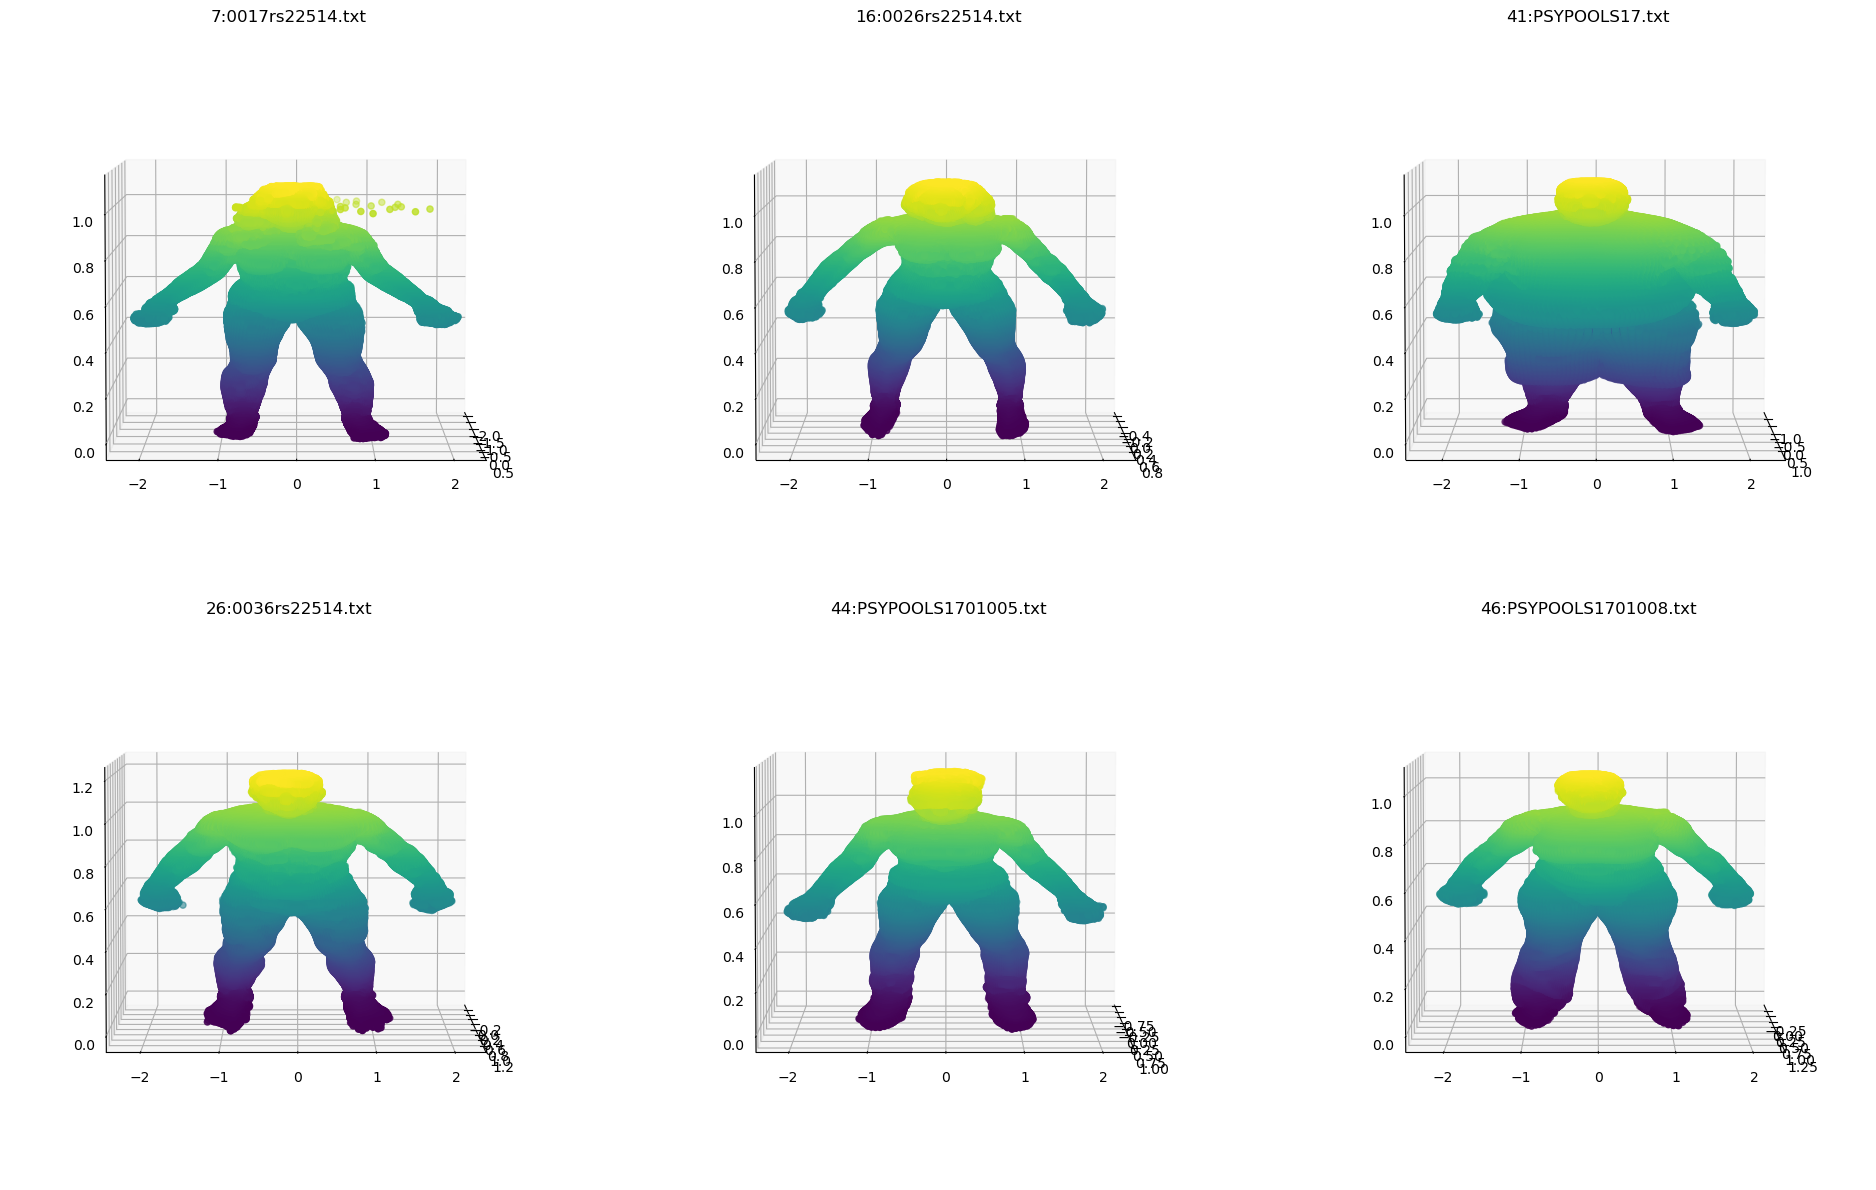

In [44]:
# Check the point to visualize and plot 
tsne_CL_rows = [[7, 16, 41],
     [26, 44, 46]]
scan_plot(tsne_CL_rows, azim=0)

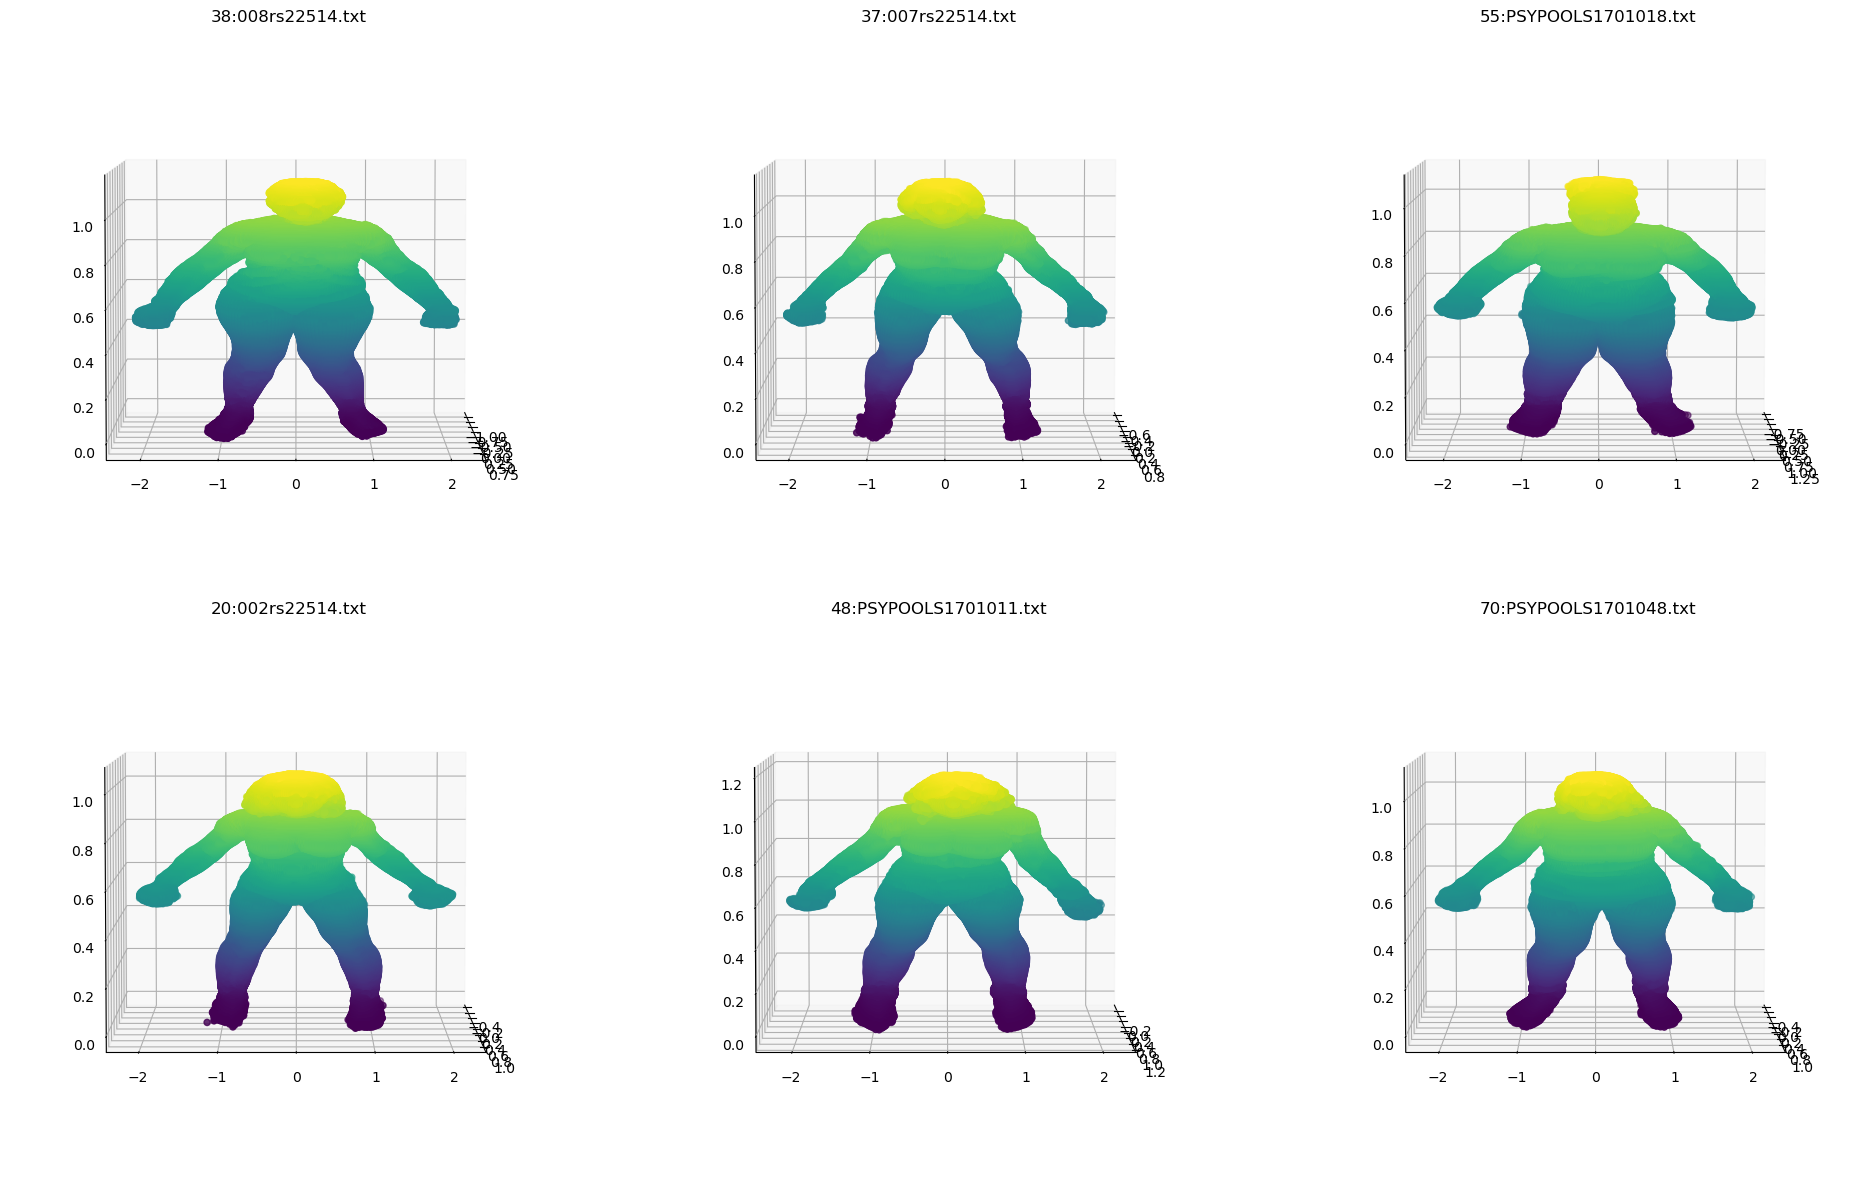

In [45]:
# For a different view
tsne_CL_rows = [[38, 37, 55],
     [20, 48, 70]]
scan_plot(tsne_CL_rows, azim=0)

# Standard Set transformer

In [46]:
# Load the trained standard set transformer
standard_ST_model = torch.load('./PCA_Tsne_Visualization/Std_Model_4115069_64_16_128_3_0.05.pth')

In [47]:
# Fit on PCA/t-SNE for visualization
true_labels, pca_transformed, X_tsne, pca = get_tsne_vector(standard_ST_model, std_flag=True)

/home/dsk2v/.conda/envs/my_miniconda_dsk2v_4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/dsk2v/.conda/envs/my_miniconda_dsk2v_4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [48]:
# Get the explained variance ratio
variance_ratio = pca.explained_variance_ratio_
total_variance = 0.0
# Print the variance percentage for each principal component
for i, ratio in enumerate(variance_ratio):
    print(f"Principal Component {i+1}: {ratio * 100:.2f}%")
    total_variance += (ratio * 100)
print(f"Total Principal Component: {total_variance:.2f}%")

Principal Component 1: 30.71%
Principal Component 2: 24.27%
Total Principal Component: 54.98%


In [49]:
# Create a scatter plot with hover labels
fig = go.Figure(data=go.Scatter(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    mode='markers',
    marker=dict(color=true_labels),
    text=[str(label)+ ': '+target_label_dict[label] for label in true_labels],  # Obtain labels from the dictionary
    hovertemplate="%{text}<extra></extra>"
))

fig.update_layout(
    title='PCA Visualization',
    xaxis_title='Component 1',
    yaxis_title='Component 2',
    hovermode='closest'
)

# fig.show()
fig.show(renderer="iframe")  # or renderer="svg"


In [50]:
# Create a scatter plot with hover labels
fig = go.Figure(data=go.Scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    mode='markers',
    marker=dict(color=true_labels),
    text=[str(label)+ ': '+target_label_dict[label] for label in true_labels],  # Obtain labels from the dictionary
    hovertemplate="%{text}<extra></extra>"
))

fig.update_layout(
    title='t-SNE Visualization for Standard Set Transformer',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    hovermode='closest'
)

# fig.show()
fig.show(renderer="iframe")  # or renderer="svg"


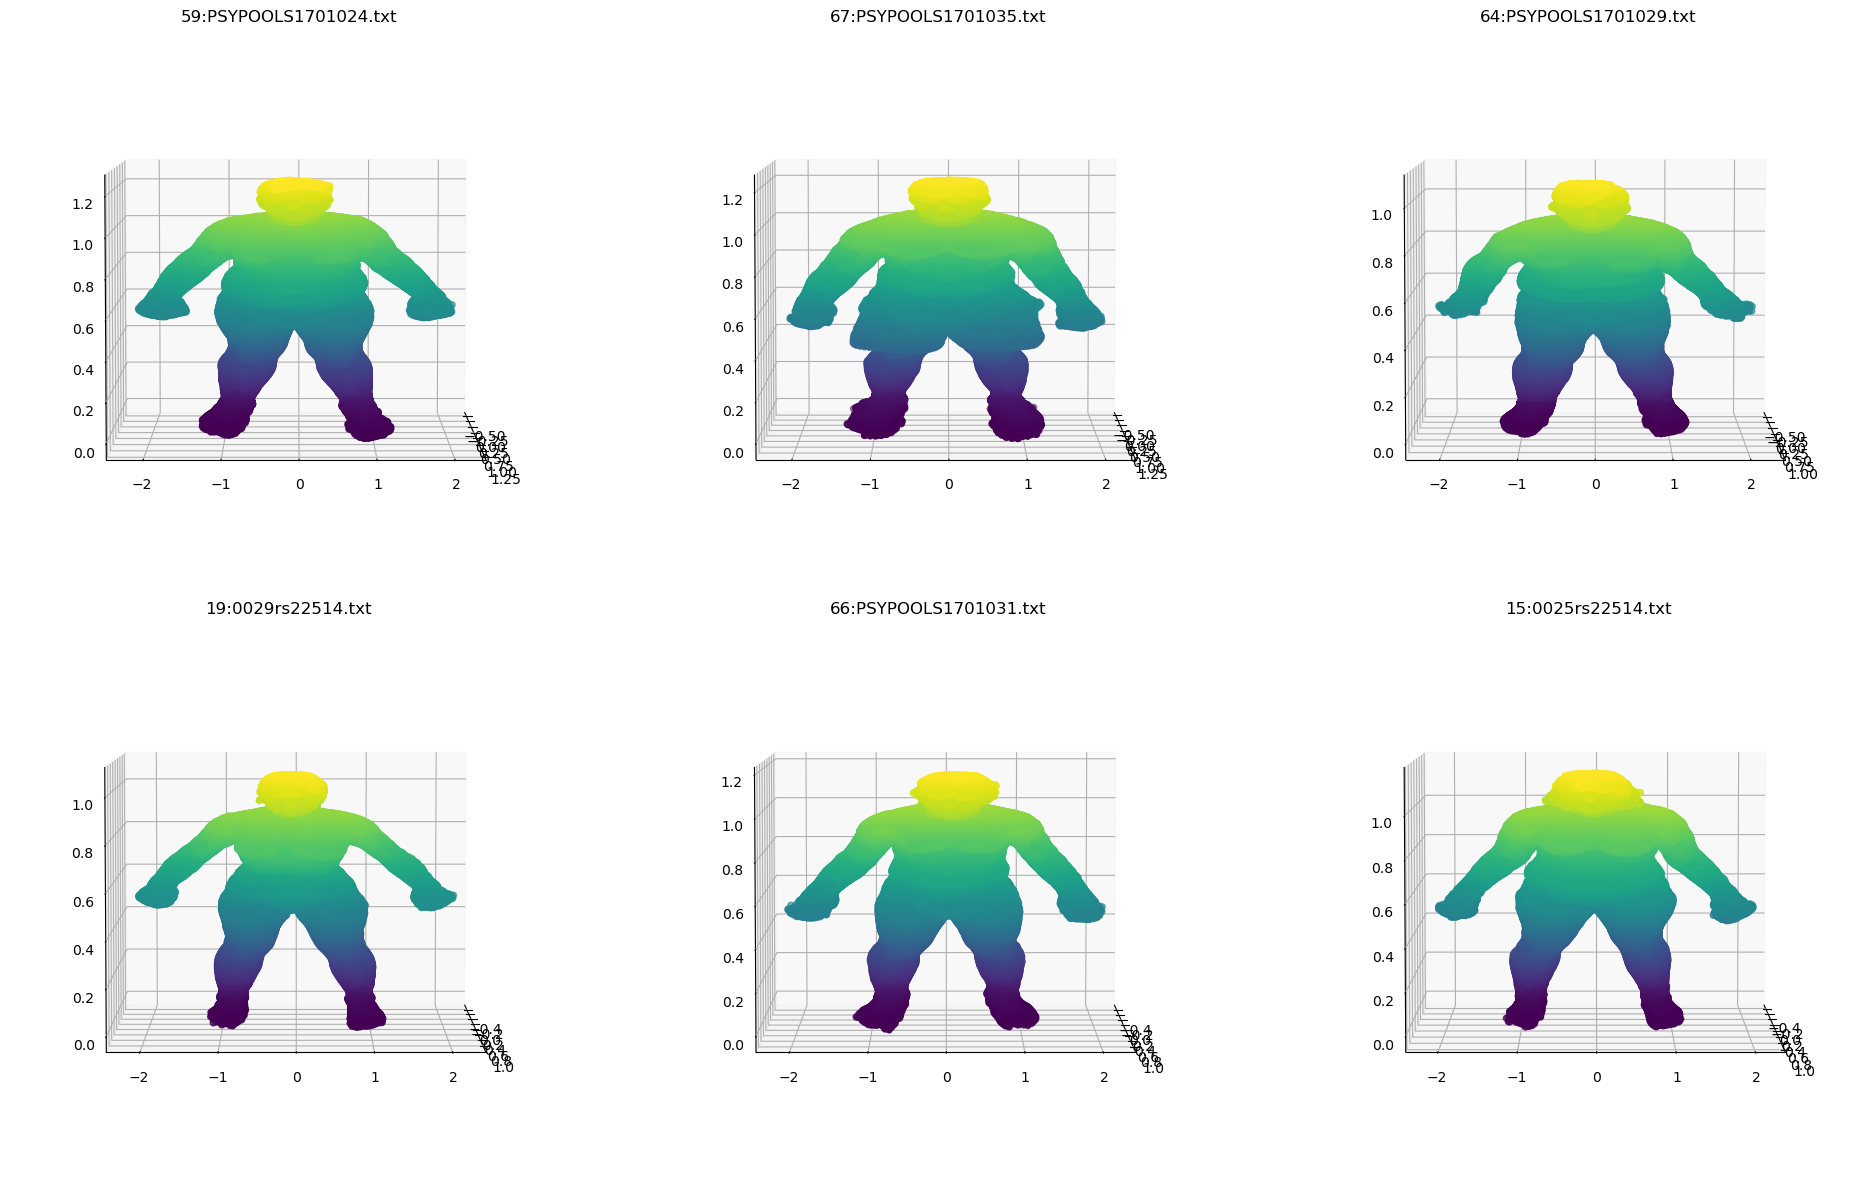

In [51]:
# Check the point to visualize and plot 
tsne_ST_rows = [[59, 67, 64],
     [19, 66, 15]]
scan_plot(tsne_ST_rows,azim=0)